In [ ]:
!python --version

Python 3.10.12


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Retrieving Data

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False) # Getting mnist dataset as NumPy arrays
X,y = mnist.data, mnist.target # Loading data and labels

In [ ]:
print(mnist.DESCR) # Description of the dataset

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [ ]:
print(X.shape)
print(y.shape) # Printing shapes of X and y to see the number of elements

(70000, 784)
(70000,)


Actual value: 5


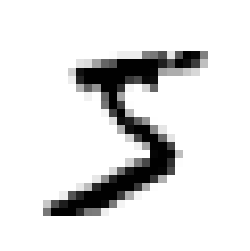

In [ ]:
def plot_digit(img_data):
    image = img_data.reshape(28, 28)
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.show()

single_digit = X[0]
print(f'Actual value: {y[0]}')
plot_digit(single_digit)

In [ ]:
# Splitting images into training and testing sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}\nX_test:{X_test.shape}, y_test:{y_test.shape}')

X_train: (60000, 784), y_train: (60000,)
X_test:(10000, 784), y_test:(10000,)


# Multiclass Classification

In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train[:2000], y_train[:2000])
svc.predict([single_digit])

array(['5'], dtype=object)

In [ ]:
# Sklearn automatically used OvO(One versus One) strategy in order to train and predict values
# It trained 45 classifiers based on the number of classes = 10. N = 10 * (10 -1 ) /2
# Model conducted duels between each class to find out which classifier had the most duels won
# It was 5, with score of 9.3 below

In [ ]:
single_digit_scores = svc.decision_function([single_digit])
single_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [ ]:
svc.classes_ # Classifier stores the labels of data in classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([single_digit])

array(['5'], dtype='<U1')

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# It means it has 10 binary models (one for each digit) based on strategy of One versus Rest

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('uint8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# Model for predicting multiple labels, such as how big the number is and its parity
knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)
knn.predict([single_digit])

array([[False,  True]])

In [ ]:
# 5 is smaller than 7, that's why it is False
# 5 is odd, that's why it is True

# Multioutput Classification (Cleaning Noise)

In [ ]:
np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise # Creating new dataset and adding some noise to it

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise # Also doing it for the test dataset

y_train_mod = X_train # Clean training images as labels
y_test_mod = X_test # Clean testing timages as labels

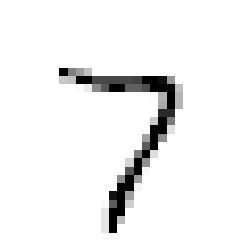

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

In [ ]:
# Pretty good noise removal, it is definitely seven
# It is called multioutput classication, because it outputs whole numpy array for a digit
# It manages to remove noise by reducing the intensity of pixel, which varies in range [0, 255]
print('Actual label: {}'.format(y_test[0]))

Actual label: 7


# Building accurate model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
params = {'n_neighbors': (3,5),
          'weights': ('uniform', 'distance')}
knn_clf = GridSearchCV(knn, params)
knn_clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (3, 5),
                         'weights': ('uniform', 'distance')})

In [ ]:
knn_clf.cv_results_

{'mean_fit_time': array([0.35037341, 0.31768675, 0.28063006, 0.33229003]),
 'std_fit_time': array([0.05190547, 0.07508177, 0.06114894, 0.06510254]),
 'mean_score_time': array([56.5488163 , 47.80786667, 45.38294816, 45.51187506]),
 'std_score_time': array([9.39041544, 5.22271474, 0.97885744, 0.52173892]),
 'param_n_neighbors': masked_array(data=[3, 3, 5, 5],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3, 'weights': 'uniform'},
  {'n_neighbors': 3, 'weights': 'distance'},
  {'n_neighbors': 5, 'weights': 'uniform'},
  {'n_neighbors': 5, 'weights': 'distance'}],
 'split0_test_score': array([0.97175   , 0.97233333, 0.96975   , 0.97033333]),
 'split1_test_score': array([0.97066667, 0.97166667, 0.97016667, 0.97133333]),
 'split2_test_score': array([0.

In [ ]:
knn_clf.best_estimator_

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [ ]:
# Best estimator has hyperparameters; n_neightbors = 3, weights = 'distance'
# Mean score is equal to 97.1%

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, f1_score

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

predictions1 = knn.predict(X_test)

In [ ]:
print('Accuracy score: {:.3f}'.format(accuracy_score(y_test, predictions1)))
print('F1: {:.3f}'.format(f1_score(y_test, predictions1, average='macro')))

Accuracy score: 0.972
F1: 0.972


In [ ]:
# We have successfully trained a model that achieves little over 97% accuracy

# Manually creating augmented images

In [ ]:
from scipy.ndimage.interpolation import shift

# Function for augmenting image based on direction
def augment_image(img, direction):
  image = img.reshape(28,28)

  def det_dir(direction):
    match direction:
      case 0: # left
        return [0, -1]
      case 1: # right
        return [0, 1]
      case 2: # up
        return [-1, 0]
      case 3: # down
        return [1, 0]

  # shift function from scipy library that is used to shift image in any direction
  return shift(image, det_dir(direction), cval=0).flatten()

<ipython-input-21-a0841d706f6f>:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [ ]:
# Creating copies of original datasets, making it smaller so it is computed faster
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [ ]:
# Loop for creating augmented images in 4 different directions

augmented_X = []
augmented_y = []

for i in range(len(X_train_copy)):
  for j in range(0, 4):
    augmented_X.append(augment_image(X_train_copy[i], j))
    augmented_y.append(y_train_copy[i])

augmented_X_train = np.array(augmented_X)
augmented_y_train = np.array(augmented_y)

X_train_copy = np.concatenate((X_train_copy, augmented_X_train), axis=0)
y_train_copy = np.concatenate((y_train_copy, augmented_y_train), axis=0)

In [ ]:
del augmented_X, augmented_y, augmented_X_train, augmented_y_train

In [ ]:
# Recreating the best performing model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

modelknn = KNeighborsClassifier(n_neighbors=3, weights='distance')
modelknn.fit(X_train_copy, y_train_copy)

pred = modelknn.predict(X_test)

In [ ]:
print('Accuracy score: {:.3f}'.format(accuracy_score(y_test, pred)))
print('F1: {:.3f}'.format(f1_score(y_test, pred, average='macro')))

Accuracy score: 0.976
F1: 0.976


In [ ]:
# Model performs even better compared to previous model, which has 0.972 accuracy!

# Binary Classifier, PR & ROC

In [ ]:
# Creating a binary classification model including only one digit - 5
y_train_five = (y_train == '5')
y_test_five = (y_test == '5')

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_five)

SGDClassifier(random_state=42)

In [ ]:
single_prediction = sgd_clf.predict([single_digit])
print('Predicted value : {}, Actual value: {}'.format(single_prediction, 'True'))

Predicted value : [ True], Actual value: True


In [ ]:
# Evaluating model using Confusion Matrix, because it is good way to evaluate classification model
from sklearn.model_selection import cross_val_predict

y_train_prediction = cross_val_predict(sgd_clf, X_train, y_train_five, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_prediction, y_train_five)
cm

array([[53892,  1891],
       [  687,  3530]])

In [ ]:
# TN = 53892 (Correctly classified as non-5)
# FP = 687 (Incorrectly classified as 5)
# FN = 1891 (Incorrectly classified as non-5)
# TP = 3530 (Correctly classified as 5)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision score: {}'.format(precision_score(y_train_five, y_train_prediction).round(2))) # About quality, how often the model is correct when predicting target class
print('Recall score: {}'.format(recall_score(y_train_five, y_train_prediction).round(2))) # About quantity, whether model can find all of the objects of target class
print('F1 score: {}'.format(f1_score(y_train_five, y_train_prediction).round(2))) # Score that favors predictions that have similar precision and recall

Precision score: 0.84
Recall score: 0.65
F1 score: 0.73


In [ ]:
# Precision - Recall tradeoff
y_scores = sgd_clf.decision_function([single_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
# This confirms that raising the threshold decreases recall.

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_five, y_scores)

idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_five, cv=3,
           method="decision_function")

In [ ]:
from sklearn.metrics import roc_curve # Receiver Operating Characteristic - tool used with binary classifications

fpr, tpr, thresholds = roc_curve(y_train_five, y_scores)

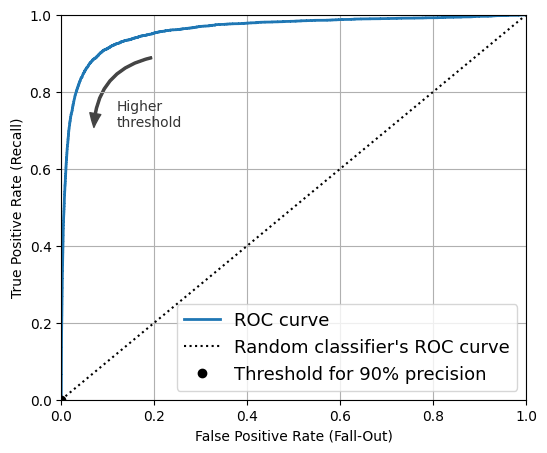

In [ ]:
from matplotlib import patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_five, y_scores).round(2)

0.96

In [ ]:
# Creating Random Forest model in order to compare its scores against SGD
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_five, cv=3,
                                    method="predict_proba")
# Random forest model does not have decision_function(), but predict_proba is fine, it returns probabilities of each class

In [ ]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [ ]:
# Model is 89% sure first image positive, while second image is negative by 99%

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
y_train_five, y_scores_forest)

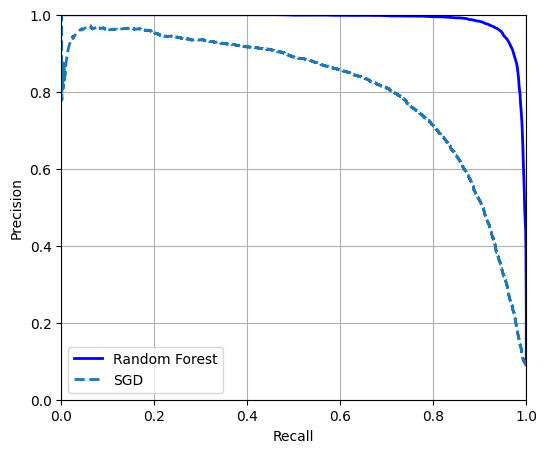

In [ ]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [ ]:
# Performance of random forest model is much better compared to SGD Classifier
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
print(f'f1: {f1_score(y_train_five, y_train_pred_forest)}')
print(f'roc_auc: {roc_auc_score(y_train_five, y_train_pred_forest)}')

f1: 0.9274509803921569
roc_auc: 0.9358174809192218
